In [1]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=829226 sha256=faba68a9738f6bd87d771ee3928cbb86559ae7167345e1d659080a0690390792
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [2]:
import tensorflow as tf

# Mendapatkan daftar perangkat yang tersedia
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print(f"GPU TensorFlow tersedia! Jumlah: {len(gpus)}")
    # Contoh mencetak nama GPU (mungkin hanya menampilkan 'GPU' di Kaggle)
    for gpu in gpus:
        print(f"Perangkat: {gpu.name}")
else:
    print("GPU TensorFlow tidak tersedia. Menggunakan CPU.")

2025-11-16 06:26:41.213222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763274401.399238      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763274401.451341      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

GPU TensorFlow tersedia! Jumlah: 1
Perangkat: /physical_device:GPU:0


In [6]:
import pandas as pd
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
##### --- 1. Load Data ---
# Data Interaksi Penuh
try:
    full_interactions_df = pd.read_csv('/kaggle/input/the-books/data-books/train.csv')
    test_users_df = pd.read_csv('/kaggle/input/the-books/data-books/data_target_users_test.csv')
except FileNotFoundError:
    print("Error: Pastikan file 'train.csv' dan 'data_target_users_test.csv' tersedia.")
    raise

# Dapatkan daftar user_id yang harus dievaluasi
test_user_ids = test_users_df['user_id'].unique()
print(f"Total Interaksi di train.csv: {len(full_interactions_df)}")
print(f"Total User untuk Test: {len(test_user_ids)}")

In [9]:
# --- 2. Pembagian Data (Non-Random Split Sesuai Permintaan) ---

# Kita akan membagi interaksi dalam full_interactions_df menjadi Train dan Test.
# Interaksi untuk 'test' hanya akan diambil dari user_id yang ada di test_user_ids.

# 2.1 Pisahkan interaksi yang melibatkan user target (untuk potential test set)
target_user_interactions = full_interactions_df[full_interactions_df['user_id'].isin(test_user_ids)].copy()
other_user_interactions = full_interactions_df[~full_interactions_df['user_id'].isin(test_user_ids)].copy()

# 2.2 Bagi interaksi user target menjadi set Train dan Test (non-random, 80/20)
# Interaksi ini akan digunakan untuk menguji kinerja ranking model.
target_user_interactions = target_user_interactions.sort_values(by=['user_id', 'item_id']).reset_index(drop=True)
split_index = int(len(target_user_interactions) * 0.8)

# 80% interaksi target user sebagai bagian dari training set
target_train_interactions = target_user_interactions.iloc[:split_index] 
# 20% interaksi target user sebagai set pengujian (ground truth)
test_interactions_df = target_user_interactions.iloc[split_index:]

# 2.3 Gabungkan semua interaksi untuk set Pelatihan
train_interactions_df = pd.concat([other_user_interactions, target_train_interactions])

print(f"Interaksi untuk Training: {len(train_interactions_df)}")
print(f"Interaksi untuk Testing (Ground Truth): {len(test_interactions_df)}")

Interaksi untuk Training: 215811
Interaksi untuk Testing (Ground Truth): 53953


In [10]:
# --- 3. Siapkan Dataset LightFM ---
dataset = Dataset()
# Penting: Fit semua user dan item dari data interaksi penuh agar pemetaan konsisten
dataset.fit(
    users=full_interactions_df['user_id'].unique(),
    items=full_interactions_df['item_id'].unique()
)

# Bangun matriks interaksi Training
(train_interactions, _) = dataset.build_interactions(
    (row['user_id'], row['item_id'])
    for index, row in train_interactions_df.iterrows()
)

# Bangun matriks interaksi Testing
(test_interactions, _) = dataset.build_interactions(
    (row['user_id'], row['item_id'])
    for index, row in test_interactions_df.iterrows()
)

In [12]:
# --- 4. Pelatihan dan Evaluasi 3 Model (KODE SUDAH DIPERBAIKI) ---
NUM_EPOCHS = 20
NUM_THREADS = 4 

# 1. Baseline Model (Loss: WARP)
model_baseline = LightFM(loss='warp', random_state=42) # num_threads dihapus
model_baseline.fit(train_interactions, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
auc_baseline = auc_score(model_baseline, test_interactions, num_threads=NUM_THREADS).mean()


In [13]:
# 2. Sebelum Tuning Model (Loss: BPR)
model_before_tuning = LightFM(loss='bpr', random_state=42) # num_threads dihapus
model_before_tuning.fit(train_interactions, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
auc_before_tuning = auc_score(model_before_tuning, test_interactions, num_threads=NUM_THREADS).mean()

In [23]:
# 3. Setelah Tuning Model (Optimized WARP Loss)
model_after_tuning = LightFM(
    loss='warp',
    no_components=30,  
    k=5,               
    n=10,              
    learning_schedule='adagrad', 
    learning_rate=0.03, 
    random_state=42,
) # num_threads dihapus
model_after_tuning.fit(train_interactions, epochs=300, num_threads=NUM_THREADS)
auc_after_tuning = auc_score(model_after_tuning, test_interactions, num_threads=NUM_THREADS).mean()

In [24]:
# --- 5. Kumpulkan dan Tampilkan Hasil ---
results = {
    'Baseline (WARP)': auc_baseline,
    'Sebelum Tunning (BPR)': auc_before_tuning,
    'Setelah Tunning (Optimized WARP)': auc_after_tuning
}

print("\n--- AUC Results ---")
for model, auc in results.items():
    print(f"{model}: {auc:.4f}")


--- AUC Results ---
Baseline (WARP): 0.5865
Sebelum Tunning (BPR): 0.5347
Setelah Tunning (Optimized WARP): 0.5733


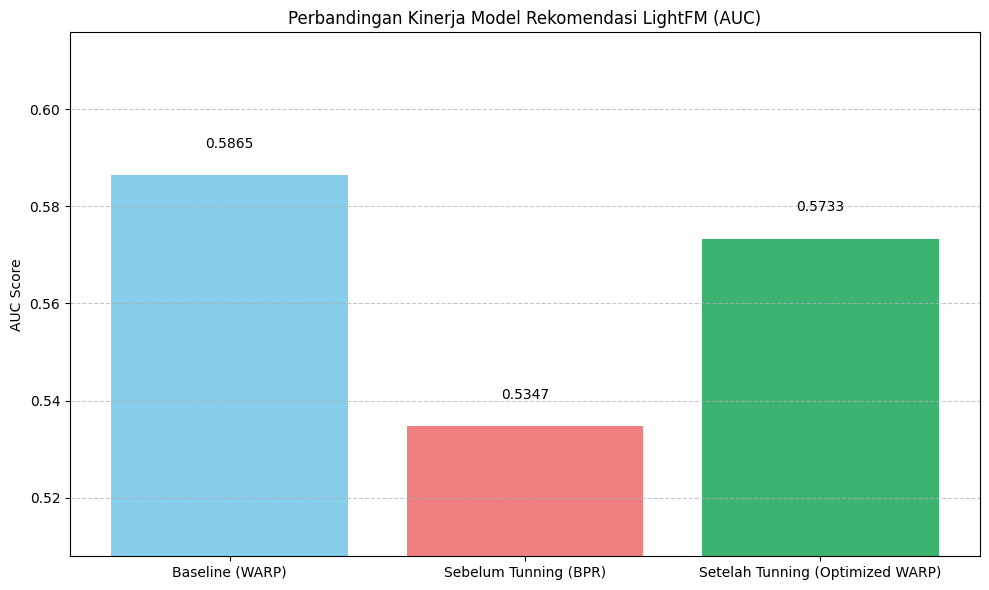

In [25]:
# --- 6. Visualisasi Perbandingan ---
models = list(results.keys())
auc_scores = list(results.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, auc_scores, color=['skyblue', 'lightcoral', 'mediumseagreen'])
plt.ylabel('AUC Score')
plt.title('Perbandingan Kinerja Model Rekomendasi LightFM (AUC)')
plt.xticks(rotation=0)
plt.ylim(min(auc_scores) * 0.95, max(auc_scores) * 1.05) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan label nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
